# 1. Introduction

In many EEG experiments, sending **event markers** (also called **triggers**) from your behavioral task software (e.g., PsychoPy) to your EEG amplifier (e.g., DSI-24) is crucial. These markers help you align recorded brain signals with specific events in your paradigm (such as stimulus onsets, responses, or condition changes).

**Why This Matters**  
- **Accurate Data Alignment**: Triggers help ensure that what you see in your EEG data directly corresponds to events in your experiment.  
- **Simpler Analysis**: Precise event markers make it easier to measure and compare brain responses to specific stimuli or conditions.  

This guide briefly explains the difference between **Tonic** (sustained) and **Phasic** (brief) triggers, how to implement them in PsychoPy/Pavlovia, and some best practices for smooth EEG-data collection.

---


# 2. Tonic vs. Phasic Triggers (Brief Overview)

## 2.1 Definitions

- **Tonic (Sustained) Triggers**  
  A trigger set to a nonzero value at the start of a long-lasting event or block (e.g., an entire experimental condition), which remains high until explicitly reset to zero.

- **Phasic (Brief) Triggers**  
  A short pulse—often just a few milliseconds—that marks a precise moment in time (e.g., a stimulus onset, a keypress).

## 2.2 When to Use Each

- **Use Tonic Triggers**  
  - **Extended Blocks/Conditions** (e.g., 2-minute rest vs. 2-minute task).  
  - **Neurofeedback** or tasks where a constant trigger value helps identify continuous phases.

- **Use Phasic Triggers**  
  - **Discrete, Time-Locked Events** (e.g., stimulus flashes, button presses).  
  - **ERP Studies** where precise event timing is crucial.

## 2.3 Why It Matters

Choosing the right trigger approach can **simplify analysis** and help you pinpoint specific EEG responses:
- **Tonic** markers make it easy to see at a glance which condition was active during extended intervals.
- **Phasic** markers provide **high temporal precision** for events like stimulus onsets and rapid responses.

---

# 3. Quick Implementation Steps in PsychoPy

This section provides a **minimal** workflow for sending triggers via PsychoPy (and by extension, Pavlovia). For more advanced usage or extended code examples, please refer to the full notebook or the “code snippets only” document.

## 3.1 Opening the Serial Port

At the very beginning of your script (e.g., “Begin Experiment” tab in PsychoPy Builder):
```python
import serial
from psychopy import core

# Replace 'COM3' (Windows) or '/dev/ttyUSB0' (Linux/macOS) with the correct port
ser = serial.Serial('COM3')
ser.write(str.encode(chr(0)))  # Ensure the trigger line starts at 0
print("Serial port opened. Trigger line reset to 0.")
```

## 3.2  Immediate vs. On-Flip Trigger Timing

When sending triggers, decide if you need them to occur **as soon as you call the function** (immediate) or **exactly on the next screen refresh (on-flip)**

- Immediate:

   ```python
   def send_trigger_phasic(ser, value, dur=0.01):
    """
    Send a brief (phasic) trigger immediately.
    ser  : serial.Serial object
    value: Integer trigger code
    dur  : How long (in seconds) to keep the trigger active
    """
    ser.write(str.encode(chr(value)))  # Turn the trigger on
    core.wait(dur)                     # Wait for 'dur' seconds
    ser.write(str.encode(chr(0)))      # Reset the trigger to 0
   ```
   This trigger fires at the exact moment your code runs, independent of screen presentation.

- On-Flip:

   ```python
   def send_trigger_onflip_phasic(win, ser, value, dur=0.01):
    """
    Schedule a brief phasic trigger to coincide with the next screen flip.
    win  : psychopy.visual.Window object
    ser  : serial.Serial object
    value: Integer trigger code
    dur  : Duration (in seconds) to keep the trigger active
    """
    def turn_trigger_on():
        ser.write(str.encode(chr(value)))  # Trigger on

    # Schedule the trigger to fire on the next flip
    win.callOnFlip(turn_trigger_on)
    win.flip()          # The trigger goes high here
    core.wait(dur)      # Keep it active briefly
    ser.write(str.encode(chr(0)))  # Reset the trigger to 0
   ```
   This approach aligns the trigger with your screen refresh, ensuring stimulus onset and EEG marker occur simultaneously.


# 3.3 Example Usage in PsychoPy Builder

- __Begin Routine__ Tab (Stimulus Onset)

    ```python
    # If 'go_stim' is the current stimulus:
    if thisTrial['stimType'] == 'go':
        send_trigger_phasic(ser, 10)  # or send_trigger_onflip_phasic(win, ser, 10)
    else:
        send_trigger_phasic(ser, 11)
    ```
- __End Routine__ Tab (Response Evaluation)

    ```python
    if 'space' in key_resp.keys:
        send_trigger_phasic(ser, 20)  # Mark correct response
    else:
        send_trigger_phasic(ser, 21)  # Mark incorrect response
    ```

---


# 4.  Implementing the Go/No-Go Experiment with Trigger Code in PsychoPy (Phasic and Tonic)

This section walks you through a **Go/No-Go** example for sending triggers with **either phasic or tonic** approaches. A more detailed, step-by-step version is available in the longer notebook. For **fully working online examples**, please see:

- **Phasic Example**: [Go/No-Go with Phasic Triggers](https://gitlab.pavlovia.org/smilingdevil/gonogo_phasic_triggers)  
- **Tonic Example**: [Go/No-Go with Tonic Triggers](https://gitlab.pavlovia.org/smilingdevil/gonogo_tonic_triggers)


## 4.1 Overall Experiment Flow

Here the goal is to present a “Go” or “No-Go” stimulus, let the participant respond (or withhold response), and send **EEG triggers** at key moments (stimulus onset, correct/incorrect response). 
- Suggested Builder Structure
   1. **Welcome Routine**  
      - Instructions or initial setup  
   2. **Trial Routine**  
      - Stimulus (Go or No-Go)  
      - Keyboard response  
      - Code component for sending triggers  
   3. **Break/End Routine**  
      - Could include a message or final triggers.

Below, you can see the **Flow** panel in PsychoPy, which sequences all the routines:

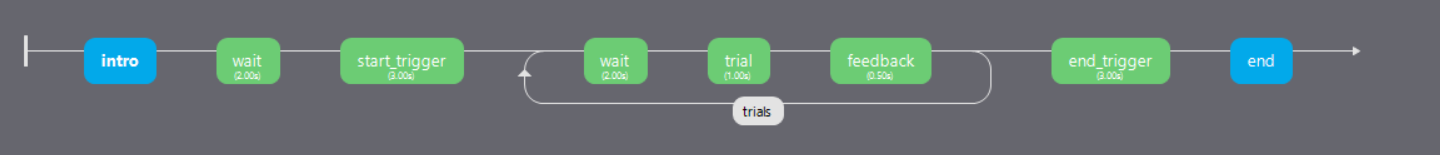
**Figure 4.1.** The experiment begins with an `intro` routine, followed by a `wait` routine (2 seconds), then a `start_trigger` routine to send initial triggers, multiple trials (enclosed in a loop named `trials`), a `feedback` routine, and finally the `end_trigger` and `end` routine.

- **Intro**: Presents instructions or a welcome screen.  
- **Wait**: A brief waiting period to let participants settle.  
- **Start_Trigger**: Initializes or sends an initial marker for the task.  
- **Trial** & **Feedback**: The main loop for Go/No-Go trials.  
- **End_Trigger** & **End**: Sends final triggers and shows a concluding screen.

## 4.2 Intro (Welcome) Routine

Within the **Intro** routine, we’ve placed two important **Code components**:

1. **import_functions**  
2. **triggers_list**

This routine runs once at the beginning of the experiment to import libraries, initialize the serial connection, and define trigger constants.

### 4.2.1 `import_functions` Code Component
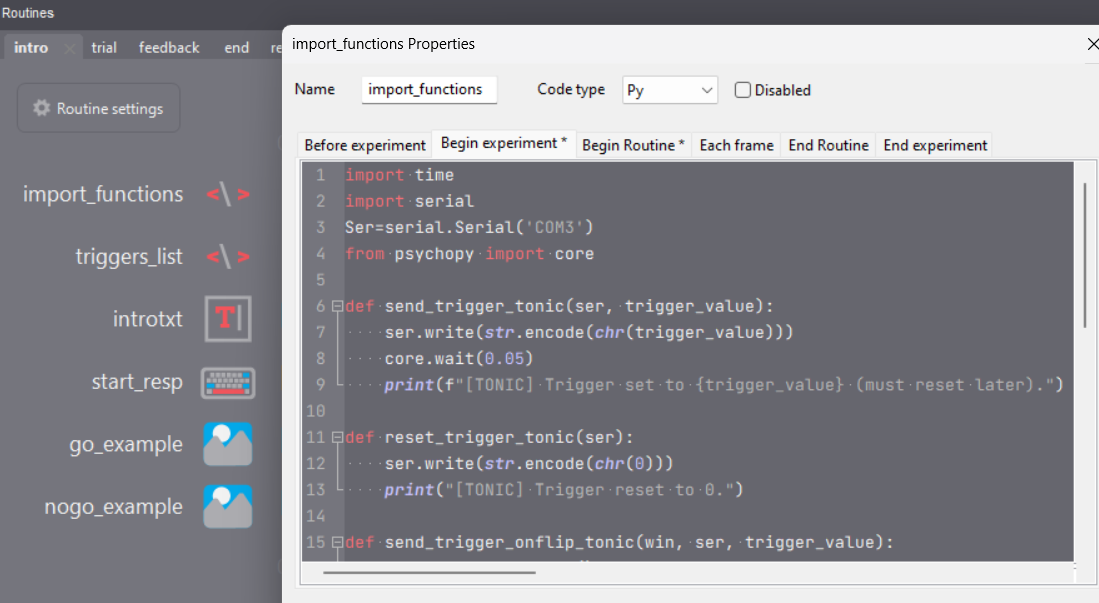
**Figure 4.2.** The `import_functions` code component contains:
- Import statements (`import serial`, `from psychopy import core`, etc.),
- The opening of the serial port (e.g., `Ser = serial.Serial('COM3')`),
- Definitions for **tonic** and/or **on-flip** trigger functions (`send_trigger_tonic`, `reset_trigger_tonic`, `send_trigger_onflip_tonic`, etc.).

All of this is placed under **“Before experiment”** or **“Begin experiment”** tabs so the serial port is opened and functions are available throughout the experiment.


### 4.2.2 `triggers_list` Code Component

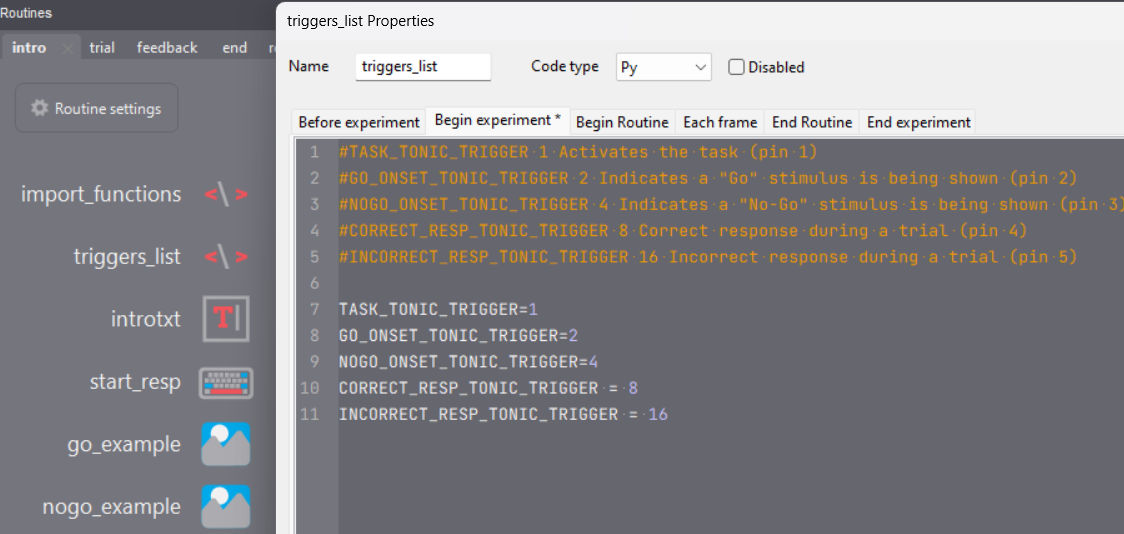

**Figure 4.3.** In `triggers_list`, we define **constants** that map trigger labels to specific integer values. For example:
```python
TASK_TONIC_TRIGGER = 1
GO_ONSET_TONIC_TRIGGER = 2
NOGO_ONSET_TONIC_TRIGGER = 4
CORRECT_RESP_TONIC_TRIGGER = 8
INCORRECT_RESP_TONIC_TRIGGER = 16

These constants make the code more readable and help ensure consistency instead of using raw numerical codes throughout the script.

## 4.3 Trial Routine

Next, we have a **Trial** routine where an image (e.g., `go.png` or `nogo.png`) is shown and a response is collected. Alongside those components, there is a **Code component** named `trigger_control` that decides which triggers to send based on the stimulus and the participant’s response.

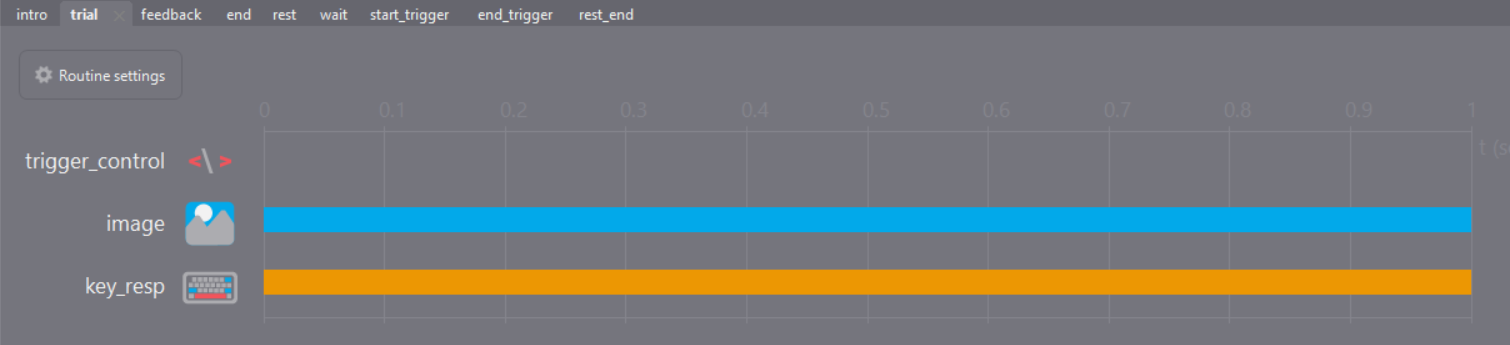

**Figure 4.4.** The trial routine includes:
- **trigger_control** (Code component),
- **image** (to display the Go or No-Go stimulus),
- **key_resp** (to capture keyboard responses).

## 4.4 The `trigger_control` Code Component

This code component is crucial for deciding **which trigger** to send and **when** to send it. It can handle both **tonic** and **phasic** triggers, depending on your design.


## 4.4.1 Begin Routine: Determining Stimulus Triggers

Below is a **side-by-side** comparison of the **tonic** and **phasic** approaches for sending triggers at stimulus onset. Note how the **tonic** code (left) sets a sustained marker, whereas the **phasic** code (right) provides a brief pulse aligned with the next screen flip.

<!-- Use an HTML table to properly align and display multi-line code in two columns. -->
<table>
  <tr>
    <th style="vertical-align: top; text-align: left; padding-right: 1em;">Tonic</th>
    <th style="vertical-align: top; text-align: left;">Phasic</th>
  </tr>
  <tr>
    <td style="vertical-align: top; padding-right: 1em;">

```python
if thisTrial['this_image'] == 'go.png':
    combined_trigger = (
        TASK_TONIC_TRIGGER
        | GO_ONSET_TONIC_TRIGGER
    )
    send_trigger_onflip_tonic(win, Ser, combined_trigger)
    print("GO_ONSET_TONIC_TRIGGER activated.")

elif thisTrial['this_image'] == 'nogo.png':
    combined_trigger = (
        TASK_TONIC_TRIGGER
        | NOGO_ONSET_TONIC_TRIGGER
    )
    send_trigger_onflip_tonic(win, Ser, combined_trigger)
    print("NOGO_ONSET_TONIC_TRIGGER activated.")
```
<p><strong>Explanation:</strong> A tonic trigger sets a sustained marker until it’s changed or reset. Perfect if you need the trigger held for the entire trial or block.</p> </td> <td>

```python
if thisTrial['this_image'] == 'go.png':
    # Example: phasic approach
    send_trigger_onflip_phasic(win, Ser, 10)
    print("GO_ONSET_PHASIC_TRIGGER activated.")
elif thisTrial['this_image'] == 'nogo.png':
    send_trigger_onflip_phasic(win, Ser, 11)
    print("NOGO_ONSET_PHASIC_TRIGGER activated.")
```

<p><strong>Explanation (Phasic):</strong> A phasic trigger provides a brief pulse aligned with the next screen flip. Ideal for marking precise event onsets without holding the line high.</p> </td> </tr> </table>

Using a tonic trigger function (left) sets a sustained marker that persists until changed or reset, while a phasic trigger function (right) provides a brief pulse aligned with the next screen flip. Both ensure that trigger onset coincides with stimulus presentation, but differ in how long the marker remains active.